# Dilation Rate Gridding Problem and How to Solve It With the Fibonacci Sequence

## Introduction

In convolutional neural networks, it is assumed that the receptive field must cover a sufficiently large area of the input image, so that the last layers of the network can have a global overview of the elements present in it.

On the figure below, we see how stacking two 3x3 convolutions will result in a 5x5 receptive field with 18 parameters (3x3 + 3x3 = 18):

[![](receptive-field.png)](https://towardsdatascience.com/a-guide-for-building-convolutional-neural-networks-e4eefd17f4fd)

There's usually 3 common ways to increase the receptive field:
1) more layers
2) pooling with strides
3) dilated convolutions.

The most used technique is to add a pooling layer. It's indeed very effective at increasing the receptive field without any added computational cost.

However, pooling can cause several issues such as [breaking the Shannon-Nyquist sampling theorem](https://richzhang.github.io/antialiased-cnns/). It also, by definition, provokes a loss of data which can be undesirable when we need to preserve the original image resolution.

The other technique uses dilated convolutions:

![](dilated-conv.png)

Dilated convolutions preserve the number of parameters and the resolution, while effectively increasing the receptive field.

However, they also come with an interesting issue: [**the gridding problem**](https://arxiv.org/abs/1702.08502).

## Problematic

Let's do some visualizations using Python and PyTorch to see how the gridding problem appears.

Some imports:

In [1]:
%matplotlib inline
import io

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch

Settings for plotting:

In [2]:
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1)
plt.rcParams["figure.figsize"] = [3, 3]
plt.rcParams["figure.dpi"] = 150
plt.rcParams["legend.fontsize"] = "large"
plt.rcParams["axes.titlesize"] = "large"
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["xtick.labelsize"] = "small"
plt.rcParams["ytick.labelsize"] = "small"

Below, we create a function that generates a neural network with $N$ convolution layers with respective dilation rates defined as a parameter:

In [3]:
def generate_network(dilation_rates: list):
    layers = []
    for dilation in dilation_rates:
        conv = torch.nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding="same",
            dilation=dilation,
            bias=False,
            padding_mode="zeros",
        )
        conv.weight.data.fill_(1)
        layers.append(conv)
    network = torch.nn.Sequential(*layers)
    return network

We also need another function that:
1) initializes the network
2) creates the input image
3) computes the output
4) returns the gradient of the output center pixel with respect to the input image.

In [4]:
def inference_and_return_grad(pixels: int, dilation_rates: list):
    net = generate_network(dilation_rates)

    input_image = torch.zeros((1, 1, pixels, pixels))
    input_image.requires_grad_(True)

    output = net(input_image)

    # we return the gradient of the output pixel center
    # with respect to the input image
    center_pixel = output[0, 0, pixels // 2, pixels // 2]
    center_pixel.backward()
    return input_image.grad

We define the input as a 21x21 pixels image:

In [5]:
pixels = 21

We create a function to help with plotting the gradient.

For all visualizations below:
- white pixels have no impact on the output center pixel
- blue pixels have an impact on the output center pixel, the darker the blue, the greater the impact.

In [6]:
def plot_grad(grad, title, show=True):
    grad = grad[0, 0]
    ax = plt.imshow(grad, cmap="Blues", interpolation="none")
    plt.title("Dilation rates: " + title)
    if show:
        plt.show()
    else:
        return ax

We first with plotting the gradient of the output center pixel w.r.t. the input for a 3-layers convolutional network without dilation ($dilation=1$):

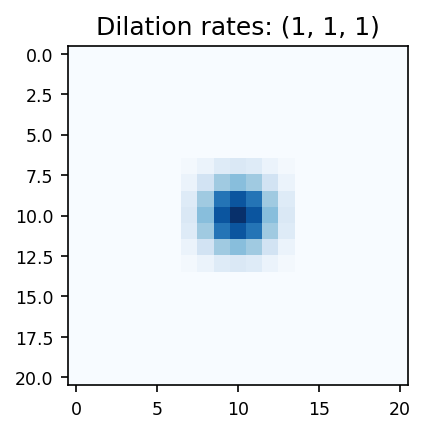

In [7]:
plot_grad(
    inference_and_return_grad(pixels, dilation_rates=(1, 1, 1)), title="(1, 1, 1)"
);

Looks good to me, it's a classic 3-layers CNN with 3x3 kernels...

Now, let's try to reproduce the gridding problem with a 4-layers CNN and a dilation rate of 2:

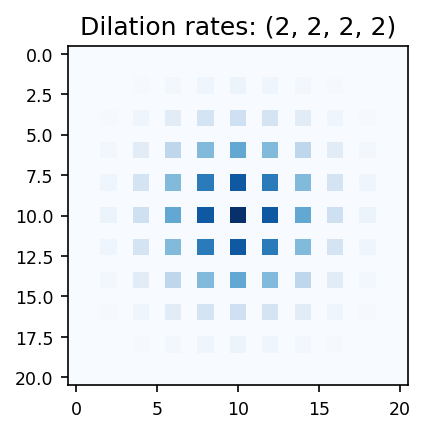

In [8]:
plot_grad(
    inference_and_return_grad(pixels, dilation_rates=(2, 2, 2, 2)), title="(2, 2, 2, 2)"
);

We can see that the output center pixel has a big receptive field encompassing the whole image, which is the purpose of dilated convolutions.

However, we also clearly notice a uniform grid of pixels not contributing to the output center pixel, which is the unwanted gridding problem.

In some neural network architectures, we sometimes see successive dilation rates growing exponentially:

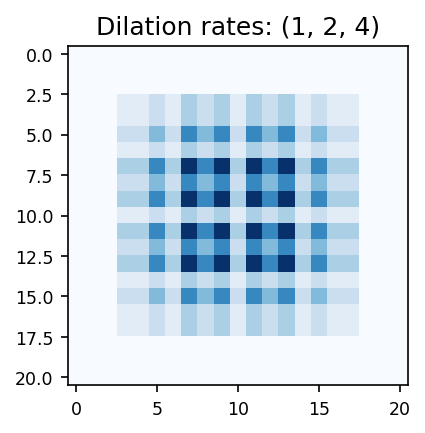

In [9]:
plot_grad(
    inference_and_return_grad(pixels, dilation_rates=(1, 2, 4)), title="(1, 2, 4)"
);

This shouldn't be used since we can see that some pixels contribute more to the output center pixel than the input center pixel itself.

## Solution

The key to solve the gridding problem is to use the Fibonacci sequence.

We can see that it effectivily solves the gridding issue:

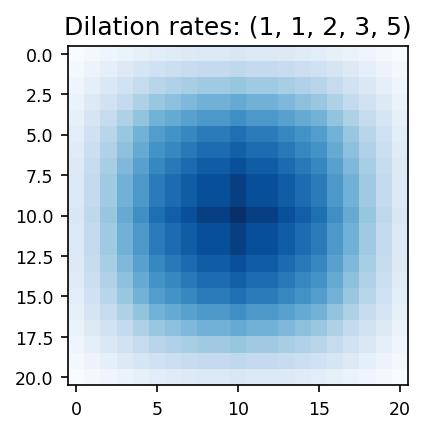

In [10]:
plot_grad(
    inference_and_return_grad(pixels, dilation_rates=(1, 1, 2, 3, 5)),
    title="(1, 1, 2, 3, 5)",
);

In [11]:
def fibonacci_sequence(seq_len: int):
    fib_seq = [1, 1]
    for _ in range(seq_len - 2):
        fib_seq.append(fib_seq[-1] + fib_seq[-2])
    return fib_seq

We can visualize the impact on the gradient of adding several conv layers with dilation rates following the Fibonacci sequence:

In [12]:
%%capture
writer = imageio.get_writer("anim.gif", mode="I", duration=1)

nb_layers_end = 6
fib_seq = fibonacci_sequence(nb_layers_end)

for nb_layers in range(1, nb_layers_end + 1):
    ax = plot_grad(
        inference_and_return_grad(pixels, dilation_rates=fib_seq[:nb_layers]),
        show=False,
        title=str(fib_seq[:nb_layers]),
    )
    buf = io.BytesIO()
    ax.figure.savefig(buf, dpi=150)
    buf.seek(0)
    pil_img = PIL.Image.open(buf)
    writer.append_data(np.array(pil_img))

![](anim.gif)